In [1]:
import yfinance as yf
import pandas as pd
from matplotlib import pyplot as plt

import numpy as np
import datetime, pickle

from lib import indicators as ind
np.set_printoptions(suppress=True)

#### Indicator Based Strategies

Uses indicators (MACD, RSI, Candlestick up/downs) to determine the trading strategy.

In [2]:
# === FETCH STOCK DATA === #

TICKER = "TSLA"

hist = yf.Ticker(TICKER).history(interval="1d", period="max")
hist.drop(columns=["Dividends", "Stock Splits"], inplace=True)

close_prices = hist.loc[:, "Close"]

In [3]:
# === CALCUALTE: EMAs, indicators === #

OFFSET = 260 * 5
GRACE = 20
CSD_THRESH = 3
SRD_THRESH = 0.05

# calculate EMAs, including the starting grace period
period = 12
data = close_prices[-OFFSET - period - GRACE + 1:].to_numpy()
hist_EMAS = ind.EMA(data, period)

period = 26
data = close_prices[-OFFSET - period - GRACE + 1:].to_numpy()
hist_EMAL = ind.EMA(data, period)

# Calculate RSI
period = 14
data = close_prices[-OFFSET - period - GRACE + 1:].to_numpy()
hist_RSI = ind.RSI(data, period)


# calculate MACD from EMAs
hist_MACD = ind.MACD(hist_EMAS, hist_EMAL)
hist_SIGLINE = ind.EMA(hist_MACD, 9)

# calculate candlestick delta from price range
hist_deltas, hist_CSD = ind.CSD(hist[-OFFSET:])

hist_SRD = ind.SRD(hist[-OFFSET:], period=14, threshold=SRD_THRESH)

# truncate grace period off of EMAs and stuff
hist_EMAS = hist_EMAS[GRACE:]
hist_EMAL = hist_EMAL[GRACE:]
hist_RSI = hist_RSI[GRACE - 1:]
hist_MACD = hist_MACD[GRACE:]
hist_SIGLINE = hist_SIGLINE[GRACE - 9 + 1:]

In [4]:
# === PLOT === #
# try:
#    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
#    ones = np.ones((hist_MACD.shape[0]))

#    '''Price, EMAs'''
#    # print(hist_EMAS)
#    # print(close_prices.to_numpy()[-OFFSET:])
#    axes[0].plot(close_prices.to_numpy()[-OFFSET:], color="green")
#    # plt.plot(hist_EMAS, color="orange")
#    # plt.plot(hist_EMAL, color="blue")
#    axes[0].set_title("Price (green), \nEMA-S (orange), \nEMA-L (blue)")


#    '''MACDs
#       positive = buy'''
#    axes[1].plot(ones - 1, color="black")
#    # plt.plot(hist_MACD, color="orange")
#    # plt.plot(hist_SIGLINE, color="blue")
#    axes[1].plot(hist_MACD - hist_SIGLINE, color="red")
#    axes[1].set_title("MACD (orange), \nSignal Line (blue), \nMACD - S-Line difference (red)")


#    '''RSI
#       RSI < 30 = buy'''
#    axes[2].plot(ones - 1, color="black")
#    axes[2].plot(100 * ones, color="black")
#    axes[2].plot(30 * ones, color="black", linestyle="dashed")
#    axes[2].plot(70 * ones, color="black", linestyle="dashed")
#    axes[2].plot(hist_RSI, color="purple")
#    # kernel = np.arange(14)[::-1]
#    # kernel = kernel / kernel.sum()
#    # plt.plot(np.convolve(hist_RSI, kernel, "same"), color="green")
#    axes[2].set_title("RSI (purple)")


#    '''CSD
#       positive = buy'''
#    axes[3].plot(ones - 1, color="black")
#    axes[3].plot(3 * ones, color="black", linestyle="dashed")
#    axes[3].plot(-3 * ones, color="black", linestyle="dashed")
#    axes[3].plot(hist_CSD, color="orange")
#    axes[3].set_title("CSD (orange)")

#    '''SRD
#       positive = buy'''
#    axes[4].plot(hist_SRD)
#    axes[4].set_title("SRD")

#    plt.show()
# except:
   # pass

In [17]:
# events = [["    Δ ≥ {0}%    ".format(SRD_THRESH * 100),
#            "-{0}% < Δ < {0}%".format(SRD_THRESH * 100),
#            "    Δ ≤ -{0}%   ".format(SRD_THRESH * 100),],

#           ["  CSD ≥ 3   ", 
#            "-3 < CSD < 3", 
#            "  CSD ≤ -3  ",],

#           ["MACD ≥ 0", 
#            "MACD < 0",],
           
#           ["  RSI ≤ 30   ", 
#            "30 < RSI < 70", 
#            "  RSI ≥ 70   ",]]

events = [["    Δ ≥ 0    ",
           "    Δ < 0    ",],

          ["  CSD ≥ 3   ", 
           "-3 < CSD < 3", 
           "  CSD ≤ -3  ",],

          ["MACD ≥ 0", 
           "MACD < 0",],
           
          ["  RSI ≤ 30   ", 
           "30 < RSI < 70", 
           "  RSI ≥ 70   ",]]

possibilities = [2, 3, 2, 3]
indicators = [hist_deltas, hist_CSD, hist_MACD, hist_RSI]
for i in range(len(indicators)):
    indicators[i] = np.repeat(indicators[i][np.newaxis, :], possibilities[i], axis=0)

'''generate one-hots for indicators'''
try:
    delta_onehot = indicators[0]
    CSD_onehot = indicators[1]
    MACD_onehot = indicators[2]
    RSI_onehot = indicators[3]

    # binomial indicators - i.e. only 2 possible events
    delta_onehot[0] = np.where(delta_onehot[0] >= 0, 1, 0)
    delta_onehot[1] = np.where(delta_onehot[1] < 0, 1, 0)


    MACD_onehot[0] = np.where(MACD_onehot[0] >= 0, 1, 0)
    MACD_onehot[1] = np.where(MACD_onehot[1] < 0, 1, 0)


    # ternary indicators - i.e. 3 possible events
    # delta_onehot[0] = np.where(delta_onehot[0] > 0, 1, 0)
    # delta_onehot[1] = np.where(delta_onehot[1] == 0, 1, 0)
    # delta_onehot[2] = np.where(delta_onehot[2] < 0, 1, 0)


    CSD_onehot[0] = np.where(CSD_onehot[0] >= CSD_THRESH, 1, 0)
    CSD_onehot[2] = np.where(CSD_onehot[2] <= -CSD_THRESH, 1, 0)
    CSD_onehot[1] = -(CSD_onehot[0] + CSD_onehot[2]) + 1


    RSI_onehot[0] = np.where(RSI_onehot[0] <= 30, 1, 0)
    RSI_onehot[2] = np.where(RSI_onehot[2] >= 70, 1, 0)
    RSI_onehot[1] = -(RSI_onehot[0] + RSI_onehot[2]) + 1
except:
    pass

P_inc, samples = ind.intersect_probs(indicators, possibilities)

'''Print out the results'''
# print("===== P(Δ ≥ 0) given different conditions =====")
# print("BE SMART! Remember that 1 - P(Δ ≥ 0) is P(Δ < 0)\n")
n = 0
total = 0
for i in range(2):
    for c in range(3):
        for m in range(2):
            for r in range(3):
                if not np.isnan(P_inc[i, c, m, r]):
                    print("{0}    {1}    {2}    {3} :  {4}%  (n = {5})".format(events[0][i], 
                                                                                events[1][c], 
                                                                                events[2][m], 
                                                                                events[3][r], "{:>6}".format(round(P_inc[i, c, m, r] * 100, 1)), 
                                                                                                           round(samples[i, c, m, r])))
                
                total += samples[i, c, m, r]

# for i in events[0]:
#     for c in events[1]:
#         for m in events[2]:
#             for r in events[3]:
#                 if not np.isnan(P_inc[i, c, m, r]):
#                     print("{0}    {1}    {2}    {3} :  {4}%  (n = {5})".format(i, c, m, r, "{:>6}".format(round(P_inc[n] * 100, 1)), round(samples[n])))
#                 total += samples[i, c, m, r]
#                 n += 1
    # print()

    Δ ≥ 0          CSD ≥ 3       MACD ≥ 0    30 < RSI < 70 :   100.0%  (n = 4)
    Δ ≥ 0          CSD ≥ 3       MACD ≥ 0      RSI ≥ 70    :   100.0%  (n = 2)
    Δ ≥ 0          CSD ≥ 3       MACD < 0    30 < RSI < 70 :   100.0%  (n = 7)
    Δ ≥ 0        -3 < CSD < 3    MACD ≥ 0    30 < RSI < 70 :    49.5%  (n = 281)
    Δ ≥ 0        -3 < CSD < 3    MACD ≥ 0      RSI ≥ 70    :    70.3%  (n = 121)
    Δ ≥ 0        -3 < CSD < 3    MACD < 0      RSI ≤ 30    :    30.8%  (n = 16)
    Δ ≥ 0        -3 < CSD < 3    MACD < 0    30 < RSI < 70 :    50.7%  (n = 242)
    Δ ≥ 0          CSD ≤ -3      MACD ≥ 0    30 < RSI < 70 :     0.0%  (n = 0)
    Δ ≥ 0          CSD ≤ -3      MACD ≥ 0      RSI ≥ 70    :     0.0%  (n = 0)
    Δ ≥ 0          CSD ≤ -3      MACD < 0    30 < RSI < 70 :     0.0%  (n = 0)
    Δ < 0          CSD ≥ 3       MACD ≥ 0    30 < RSI < 70 :     0.0%  (n = 0)
    Δ < 0          CSD ≥ 3       MACD ≥ 0      RSI ≥ 70    :     0.0%  (n = 0)
    Δ < 0          CSD ≥ 3       MACD < 0    

c:\Users\jason\Documents\Projects\StockPredictor\lib\indicators.py:181: RuntimeWarning: invalid value encountered in divide
  P_inc_with_givens = P_deltas / P_indicators


In [19]:
TESTS = 500
SHOW_PLOTS = False
TRADING_LENGTH = 30


data_orig = np.vstack((hist_SRD, hist_CSD, hist_MACD, hist_RSI,)).T
deltas = np.ndarray((TESTS,))
deltas_ideal = np.ndarray((TESTS,))

# print(data_orig.shape)
open_prices = hist.loc[:, "Open"].to_numpy()

#===========================#

for i in range(TESTS):
    values = np.ndarray((TRADING_LENGTH + 1,))
    values_ideal = np.ndarray((TRADING_LENGTH + 1,))
    prices = np.ndarray((TRADING_LENGTH + 1,))

    print("TEST #" + str(i), end="\r")
    # OFFSET = np.random.randint(SPLIT_INDEX)
    OFFSET = np.random.randint(1300 - TRADING_LENGTH)
    # OFFSET = 100

    N = data_orig.shape[0] - OFFSET - TRADING_LENGTH

    prices = open_prices[N:N + TRADING_LENGTH + 1]
    data = data_orig[N:N + TRADING_LENGTH + 1]
    print(hist.index[N])

    owned = False
    money = prices[0]
    values[0] = money

    owned_ideal = False
    money_ideal = prices[0]
    values_ideal[0] = money_ideal

    ''' TRADING LOOP FOR EACH TEST '''
    for x in range(TRADING_LENGTH):
        current_value = prices[x]

        # buy
        delta_event = data[x, 0]
        CSD_event = data[x, 1]
        MACD_event = data[x, 2]
        RSI_event = data[x, 3]

        # manually go thru cases
        if delta_event >= 0:
            d = 0
        elif delta_event < 0:
            d = 1
        else:
            d = 2
        
        if CSD_event >= CSD_THRESH:
            c = 0
        elif CSD_event <= -CSD_THRESH:
            c = 2
        else:
            c = 1

        if MACD_event >= 0:
            m = 0
        else:
            m = 1

        if RSI_event <= 30:
            r = 0
        elif RSI_event >= 70:
            r = 2
        else:
            r = 1

        # find probability from the table from above
        prob_inc = P_inc[0, c, m, r]
        prob_dec = P_inc[1, c, m, r]
        if prob_inc == np.nan:
            prob_inc = 0
        if prob_dec == np.nan:
            prob_dec = 0

        # print(prob_inc)
        # print(prob_dec)

        if (prob_inc > 0.55) and (not owned):
            owned = True
            money -= current_value
            print(str(x) + ": " + str(prob_inc) + " > " + str(0.5) + ": BUY")
        # sell
        elif (prob_dec > 0.4) and (owned):
            owned = False
            money += current_value
            print(str(x) + ": " + str(prob_dec) + " > " + str(0.5) + ": SELL")

        if owned:
            values[x + 1] = prices[x + 1] + money
        else:
            values[x + 1] = money

        ''' IDEAL PERFORMANCE ''' 
        new_value = prices[x + 1]
        # buy
        if (new_value > current_value) and (not owned_ideal):
            owned_ideal = True
            money_ideal -= current_value
            # print(str(x) + ": " + str(new_value) + " > " + str(current_value) + ": BUY")
            # print(str(money_ideal))
            # print(str(current_value + money_ideal))
        # sell
        elif (new_value < current_value) and (owned_ideal):
            owned_ideal = False
            money_ideal += current_value
            # print(str(x) + ": " + str(new_value) + " < " + str(current_value) + ": SELL")

        if owned_ideal:
            values_ideal[x + 1] = prices[x + 1] + money_ideal
        else:
            values_ideal[x + 1] = money_ideal
        # print("value at step " + str(x) + ": " + str(values[x]))

    deltas[i] = values[-1] / prices[-1] - 1
    deltas_ideal[i] = values_ideal[-1] / prices[-1] - 1

    ''' DISPLAY DIAGNOSTICS '''

    if SHOW_PLOTS:
        ### VALUE OF PORTFOLIO
        print("PLOT: Value from trading vs. value from leaving in S&P500")
        plt.plot(values, color="orange")
        plt.plot(values_ideal, color="green")
        plt.plot(prices, color="blue")
        plt.grid()
        plt.show()

        plt.plot(data[:, 2], color="orange")
        plt.grid()
        plt.show()

        plt.plot(data[:, 3], color="green")
        plt.grid()
        plt.show()

2012-10-03 00:00:00-04:00
2014-05-28 00:00:00-04:00
2014-04-15 00:00:00-04:00
0: 0.7034883720930232 > 0.5: BUY
1: 0.5052816901408451 > 0.5: SELL
2012-12-12 00:00:00-05:00
2010-08-11 00:00:00-04:00
2012-07-11 00:00:00-04:00
16: 0.7034883720930232 > 0.5: BUY
22: 0.5052816901408451 > 0.5: SELL
23: 0.7034883720930232 > 0.5: BUY
27: 0.5052816901408451 > 0.5: SELL
2011-11-28 00:00:00-05:00
2015-01-06 00:00:00-05:00
22: 0.7034883720930232 > 0.5: BUY
2015-03-11 00:00:00-04:00
1: 0.7034883720930232 > 0.5: BUY
3: 0.5052816901408451 > 0.5: SELL
10: 0.7034883720930232 > 0.5: BUY
13: 0.5052816901408451 > 0.5: SELL
2011-07-12 00:00:00-04:00
0: 0.7034883720930232 > 0.5: BUY
16: 0.5052816901408451 > 0.5: SELL
2014-04-23 00:00:00-04:00
2010-08-19 00:00:00-04:00
2011-06-27 00:00:00-04:00
5: 0.7034883720930232 > 0.5: BUY
26: 0.5052816901408451 > 0.5: SELL
2010-10-06 00:00:00-04:00
21: 1.0 > 0.5: BUY
22: 0.49266247379454925 > 0.5: SELL
2013-02-01 00:00:00-05:00
2013-06-27 00:00:00-04:00
0: 0.7034883720930

Mean: -2.155773004625155
Ideal mean: 32.69932507682615

E[x]: -2.714854754623331
Ideal E[x]: 30.6822516058549


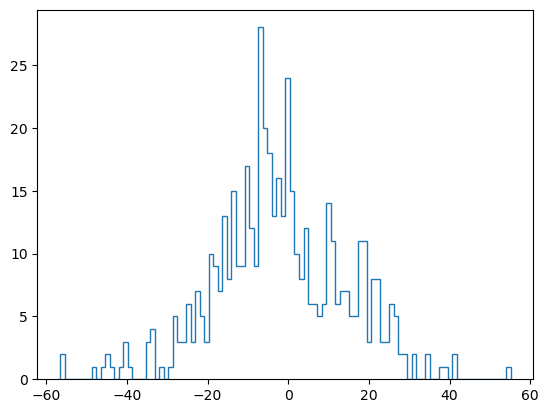

In [20]:
# a = np.clip(deltas, -0, 0)
a = deltas * 100
b = deltas_ideal * 100

hgram = np.histogram(a, bins=100, density=False)
frequencies = hgram[0]
probabilities = hgram[0] / TESTS
expected = np.sum(hgram[1][:-1] * probabilities)

print("Mean: " + str(np.mean(a)))
print("Ideal mean: " + str(np.mean(b)))
print()
print("E[x]: " + str(expected))
print("Ideal E[x]: " + str(expected_ideal))

plt.stairs(hgram[0], hgram[1])
plt.show()

In [ ]:
a = np.arange(12).reshape((3, 4))
b = np.arange(8).reshape((2, 4))

c = np.concatenate((a, b))
print(c)

In [ ]:
from lib import indicators as ind
import numpy as np

a = np.arange(8).reshape((2, 4))
b = np.arange(12).reshape((3, 4))
c = np.arange(8).reshape((2, 4)) + 1
d = np.arange(16).reshape((4, 4)) + 1

a = np.array(((0, 0, 1, 1), (0, 1, 1, 0)))
b = np.array(((0, 1, 0, 1), (0, 0, 0, 1), (1, 1, 1, 1)))
# print(a)
# print(b)
# print(c)
# print(d)

e, _ = ind.intersect_probs([a, b, c, d], [2, 3, 3, 4])
# e, f = ind.intersect_probs([a, b], [2, 3])
print(e.shape)
print(e)
# print(f)


In [ ]:
# print(range(1, 5, -1))
for x in range(5, 1, -1):
    print(x)

In [ ]:

a = np.arange(3)
b = np.arange(12).reshape((4,3))
print(a * b)